In [1]:
import os
import uuid
from datetime import datetime
from pathlib import Path

import imageio.v3 as iio
import matplotlib.pyplot as plt
import numpy as np
import pynwb
from dateutil.tz import tzlocal

nwb format is very flexible. This notebook aims at defining one way to use the format so that data sharing is facilitated among us. Feel free to read the [pynwb doc](https://pynwb.readthedocs.io/en/latest/) and suggest some improvements. 

This notebook covers:

* writing a NWB file (ecog, kinematic, image, events, extra data)
* reading a NWB file

The very important rules to follow are the keys used to store the data. Use `ecog` for ECoG data, `kinematic` for kinematic data, ...

If you need help, please feel free to reach me after checking the online doc :). 

*Etienne de Montalivet - Wyss Center*

## Create a new NWB file

First, let's create the file itself. For that, you need the following:

* measurement date
* a **unique** ID 
    * please don't use *date_time* or something human-generated. The purpose is to create a file signature that ensures two files with same ID are identical
* session description
    * every file must be self-sufficient, so session description can be duplicated
* session id
    * kind of similar to unique id, but readable by human. I suggest something like: `<subject>__<date>__<task>`. Feel free to adapt to your case.

In [2]:
# measurement date
meas_date = datetime.strptime("20240819_180001", "%Y%m%d_%H%M%S").astimezone(tz=tzlocal())
# unique id
unique_id = str(uuid.uuid4())
# session description
session_description = "Subject was asked to perform the task of moving the right arm blablabla"
# session id
session_id = "[subject]__[date]__[task]"
# notes if any
notes = "This is not a note."

In [3]:
# let's create the nwbfile
nwbfile = pynwb.NWBFile(
    session_description=session_description,
    identifier=unique_id,
    session_start_time=meas_date,
    lab="lab_name",
    institution="guess",
    session_id=session_id,
    notes=notes,
)

In [4]:
# let's check how it looks like
nwbfile

root pynwb.file.NWBFile at 0x2606306823568
Fields:
  file_create_date: [datetime.datetime(2024, 9, 19, 8, 39, 34, 284903, tzinfo=tzlocal())]
  identifier: 3db420de-0433-456e-9c4b-d5e6bf44f310
  institution: guess
  lab: lab_name
  notes: This is not a note.
  session_description: Subject was asked to perform the task of moving the right arm blablabla
  session_id: [subject]__[date]__[task]
  session_start_time: 2024-08-19 18:00:01+02:00
  timestamps_reference_time: 2024-08-19 18:00:01+02:00

### ECoG data

Please use the key `ecog` to store the data. Not `ECoG` or `ECOG`. Just `ecog`. If you want to store EMGs, please use `emg`.

Let's add some ecog data. Wait, first, we need to create many things, such as the device, the electrode group(s), and some information about the electrodes. Here we add the electrodes location, feel free to add any other useful information about the electrodes.

In [5]:
N_CHANNELS = 32
ecog_data = np.random.randn(N_CHANNELS, 10000)
ecog_sfreq = 1000.0  # Hz
ecog_ch_names = [f"ch_{i}" for i in range(N_CHANNELS)]
# optional
ecog_position = np.random.randn(N_CHANNELS, 2)

In [6]:
# device creation
device = nwbfile.create_device(
    name="WImagine system",
    description="WImagine ECoG 64 channels",
    manufacturer="Clinatec, France",
)
nwbfile.add_electrode_column(name="label", description="label of electrode")
# (optional) Electrodes location
nwbfile.add_electrode_column(
    name="x",
    description="the coordinate of the electrode in tens of mm. Needs to be aligned with brain anatomy",
)
nwbfile.add_electrode_column(
    name="y",
    description="the coordinate of the electrode in tens of mm. Needs to be aligned with brain anatomy",
)
nwbfile.add_electrode_column(
    name="any_other_info",
    description="Any other info",
)
# electrodes group - if relevant, use multiple
ecog_group = nwbfile.create_electrode_group(
    name="ecog_group",
    description="all electrodes of device",
    device=device,
    location="motor cortex - right hemisphere",
)
# fill electrodes information
for i_ch, ch_name in enumerate(ecog_ch_names):
    nwbfile.add_electrode(
        group=ecog_group,
        label=f"{ch_name}",
        x=ecog_position[i_ch][0],
        y=ecog_position[i_ch][1],
        any_other_info="indeed",
        location="motor cortex - right hemisphere",
    )
# create table region (used by pynwb later)
all_table_region = nwbfile.create_electrode_table_region(
    region=list(range(len(ecog_ch_names))),
    description="all electrodes",
)

You can see that nwbfile object now contains all the information about the electrodes:

In [7]:
nwbfile

,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed
3,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_3,0.690773,-0.644931,indeed


Let's add the data. Please check the [online documentation](https://pynwb.readthedocs.io/en/stable/pynwb.ecephys.html#pynwb.ecephys.ElectricalSeries) to see all the possible arguments.

In [8]:
ecog_ts = pynwb.ecephys.ElectricalSeries(
    name="ecog",  # mandatory: use this key and only this key
    data=ecog_data.T,  # note the transpose here. shape must be (times, channels)
    electrodes=all_table_region,
    rate=ecog_sfreq,
    conversion=1.0,  # if known, the conversion ratio from raw to Volts
)
nwbfile.add_acquisition(ecog_ts)

In [9]:
# check the new entry: acquisition
nwbfile

,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed
3,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_3,0.690773,-0.644931,indeed
,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed


### Kinematic data

Let's add the kinematic data. Please use the following structure:

* `'kinematic'` key is always used for the data of interest. It is stored in one `pynwb.behavior.Position()`. If you have some extra data, such as the kinematic of experimenter, it should be under a new `pynwb.behavior.Position()` with a different key: `'kinematic__experimenter`

* any type of kinematic data is then stored using `pynwb.behavior.SpatialSeries()`. The name should following the convention: `<type>__<joint(s)>__<left/right>`
    * examples: `position__wrist__left`, `angle__shoulder_ab__right`, `velocity__hand__left`

In [10]:
kinematics = []
for joint_name in ["wrist", "elbow", "shoulder"]:
    kinematics.append(
        pynwb.behavior.SpatialSeries(
            name="position__" + joint_name + "__right",
            description="(x,y,z) position",
            data=np.random.rand(10000, 3),
            rate=ecog_sfreq,  # here we have aligned data with ecog
            reference_frame="unknown",
        )
    )

Again, feel free to check the [online documentation](https://pynwb.readthedocs.io/en/stable/pynwb.behavior.html#pynwb.behavior.SpatialSeries) to see the different available options.

For example, you can also use timestamps instead of fixed sampling rate. 

**Note that it is recommended to align and synchronize all the data if possible.** If needed, upsampling can be applied to kinematic (but must be mentionned in session_description if used)

In [11]:
# let's say we have first 5 seconds of elbow angle sampled at 120Hz
timestamps = np.arange(600) / 120
kinematics.append(
    pynwb.behavior.SpatialSeries(
        name="angle__elbow__right",
        description="angle in radians",
        data=np.random.rand(600, 1),
        timestamps=timestamps,  # by default, 0 is the start of all sampled data
        reference_frame="unknown",
    )
)

In [12]:
# we finally create the Position container and add it to the nwbfile
motions = pynwb.behavior.Position(spatial_series=kinematics, name="kinematic")
nwbfile.add_acquisition(motions)

In [13]:
# check the new entry in acquisition
nwbfile

,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed
3,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_3,0.690773,-0.644931,indeed
,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed


### Events

You can add events using [`pynwb.epoch.TimeIntervals()`](https://pynwb.readthedocs.io/en/stable/pynwb.epoch.html#pynwb.epoch.TimeIntervals). By default it gets a `start_time` and `stop_time` columns. You can manually add extra columns.

In [14]:
%%capture
events_nwb = pynwb.epoch.TimeIntervals(
    name="cues",
    description="the experiment's cues",
)
events_nwb.add_column(
    name="cue",
    description="movements that were asked to the patient",
)
events_nwb.add_column(
    name="any_other_columns",
    description="your call",
)

cues = [
    [0.5, 1.4, "hand_open", "it was fun"],
    [3.0, 5.1, "hand_close", "even more fun"],
    [7.0, 8.0, "eat sushi", "I love sushi"],
]

for cue in cues:
    events_nwb.add_row(
        start_time=cue[0],
        stop_time=cue[1],
        cue=cue[2],
        any_other_columns=cue[3],
    )
nwbfile.add_time_intervals(events_nwb)

In [15]:
# See the new intervals entry
nwbfile

,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed
3,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_3,0.690773,-0.644931,indeed
,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed


### Image

Please use the key `electrodes_location` to refer to the location of the electrodes.

In [16]:
im_filepath = Path("../../data/example_image.jpg")

im_data = iio.imread(im_filepath)
if im_data.shape[-1] == 3:
    image_nwb = pynwb.image.RGBImage(
        name="electrodes_location",
        data=im_data,
        resolution=70.0,
        description="Location of electrodes",
    )
elif im_data.shape[-1] == 4:
    image_nwb = pynwb.image.RGBAImage(
        name="electrodes_location",
        data=im_data,
        resolution=70.0,
        description="Location of electrodes",
    )
else:
    raise ValueError(f"im_data shape is {im_data.shape}, what the ?")
images = pynwb.image.Images(
    name="images",
    images=[image_nwb],  # you can add multiple images here
    description="Images related to the experiement",
)
nwbfile.add_acquisition(images)  # you could add the images under scratch. See next section

In [17]:
# check the new entry in acquisition
nwbfile

,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed
3,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_3,0.690773,-0.644931,indeed
,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed


### Extra data that are probably useless but that I want to keep anyway

If for some reason you have some extra data that do not fit into kinematic or electrical physiological recordings, you may want to use the scratch container and the `pynwb.misc.AbstractFeatureSeries`

In [18]:
%%capture
extra_data = pynwb.misc.AbstractFeatureSeries(
    name="body__temperature",
    feature_units=["degrees" for _ in range(2)],
    features=["temp__hand__left", "temp__hand__right"],
    data=np.random.rand(10, 2),
    timestamps=np.arange(10)/1.0, # just to get ride of the warning
    description="Additional useless information",
)
nwbfile.add_scratch(extra_data)

In [19]:
# our final NWB file
nwbfile

,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed
3,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_3,0.690773,-0.644931,indeed
,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,"ecog_group pynwb.ecephys.ElectrodeGroup at 0x2606306904528\nFields:\n description: all electrodes of device\n device: WImagine system pynwb.device.Device at 0x2604965919632\nFields:\n description: WImagine ECoG 64 channels\n manufacturer: Clinatec, France\n\n location: motor cortex - right hemisphere\n",ecog_group,ch_2,-0.989244,0.633442,indeed


### Save the NWB file

In [20]:
with pynwb.NWBHDF5IO("../../data/sample.nwb", "w") as io:
    io.write(nwbfile)

### Extra notes

**datetime:**  
Please try as much as possible to use the following format:  
``<year><month><day>_<hours><minutes><seconds>``

Example: ``20240917_170015``

In any case, use a format that follows the same order.

**snakecase**:  
Please use snakecase for any new keys you introduce: don't use `ECG`, use `ecg`. If you feel a separator is needed, use double `__` so that single `_` can be used for information that need multiple words (ex: `shoulder_abduction` when refering to an angle) (yes, I know, this example is not the best...)

## Read NWB file

In [21]:
io = pynwb.NWBHDF5IO(
    "../../data/sample.nwb",
    "r",
)
read_nwbfile = io.read()

In [22]:
# events
df_cues = read_nwbfile.intervals["cues"].to_dataframe()
df_cues.head()

,start_time,stop_time,cue,any_other_columns
id,,,,
0,0.5,1.4,hand_open,it was fun
1,3.0,5.1,hand_close,even more fun
2,7.0,8.0,eat sushi,I love sushi


In [23]:
# ecog data
ecog_data = read_nwbfile.acquisition["ecog"].data[()]
ecog_data.shape

(10000, 32)

In [24]:
# electrodes
df_electrodes = read_nwbfile.electrodes.to_dataframe()
df_electrodes.head()

,location,group,group_name,label,x,y,any_other_info
id,,,,,,,
0,motor cortex - right hemisphere,ecog_group pynwb.ecephys.ElectrodeGroup at 0x2...,ecog_group,ch_0,-0.645836,0.424771,indeed
1,motor cortex - right hemisphere,ecog_group pynwb.ecephys.ElectrodeGroup at 0x2...,ecog_group,ch_1,0.848388,0.436350,indeed
2,motor cortex - right hemisphere,ecog_group pynwb.ecephys.ElectrodeGroup at 0x2...,ecog_group,ch_2,-0.989244,0.633442,indeed
3,motor cortex - right hemisphere,ecog_group pynwb.ecephys.ElectrodeGroup at 0x2...,ecog_group,ch_3,0.690773,-0.644931,indeed
4,motor cortex - right hemisphere,ecog_group pynwb.ecephys.ElectrodeGroup at 0x2...,ecog_group,ch_4,-0.982183,-0.713061,indeed


In [25]:
# kinematic keys
joints = list(nwbfile.acquisition["kinematic"].spatial_series.keys())
joints

['position__wrist__right',
 'position__elbow__right',
 'position__shoulder__right',
 'angle__elbow__right']

In [26]:
# kinematic data of specific key
joint_data = nwbfile.acquisition["kinematic"].spatial_series[joints[0]].data[()]
joint_data.shape

(10000, 3)

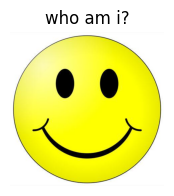

In [27]:
# image
ecog_location_image = nwbfile.acquisition["images"].images["electrodes_location"].data[()]
plt.figure(figsize=(2, 2))
plt.imshow(ecog_location_image)
plt.axis("off")
plt.title("who am i?")
plt.show()

In [28]:
# from scratch
labels = read_nwbfile.scratch["body__temperature"].features[()]
data = read_nwbfile.scratch["body__temperature"].data[()]
print(labels)
print(data.shape)

['temp__hand__left' 'temp__hand__right']
(10, 2)


In [29]:
# don't forget to close the io handler
io.close()